In [30]:
import os
import torch
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import torchvision.transforms.functional as F
import time
import torch
import cv2
import time
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchsummary import summary

print(torch.__version__)

1.13.0+cu117


In [2]:
# see what GPU is currently being used

print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

3
0
NVIDIA GeForce GTX 1080 Ti


In [3]:
# set to selected GPU

device_id = 2

torch.cuda.set_device(device_id)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(device_id))

2
NVIDIA GeForce GTX 1080 Ti


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**PREPARE DATASET**

The dataset consists of 19,200 images of cells but only 1,200 masks. The first step is to match up the images with their ground truth masks.

In [5]:
image_path = '/data1/rlubenow/BBBC005_v1_images/'
mask_path = '/data1/rlubenow/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/'

image_paths = sorted(os.listdir(image_path))
mask_paths = sorted(os.listdir(mask_path))

len(image_paths), len(mask_paths)

(19201, 1201)

In [6]:
image_paths[:5], mask_paths[:5]

(['.htaccess',
  'SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF'],
 ['.htaccess',
  'SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF'])

We want to remove the '.htaccess' file because it is of no use to us.

In [7]:
image_paths.remove('.htaccess')
mask_paths.remove('.htaccess')

len(image_paths), len(mask_paths)

(19200, 1200)

In [8]:
image_paths[:5], mask_paths[:5]

(['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s03_w1.TIF'],
 ['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
  'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
  'SIMCEPImages_A01_C1_F1_s03_w1.TIF'])

Now we want to create a list of all images that have an associated mask:

In [9]:
new_list = sorted(list(set(image_paths) & set(mask_paths)))
len(new_list), type(new_list)

(1200, list)

In [10]:
new_list[:5]

['SIMCEPImages_A01_C1_F1_s01_w1.TIF',
 'SIMCEPImages_A01_C1_F1_s01_w2.TIF',
 'SIMCEPImages_A01_C1_F1_s02_w1.TIF',
 'SIMCEPImages_A01_C1_F1_s02_w2.TIF',
 'SIMCEPImages_A01_C1_F1_s03_w1.TIF']

Now that we have our list of 1200 images and their associated masks, lets split this into train and test sets:

In [11]:
train_list, test_list = train_test_split(new_list,
                                         test_size=0.1)

len(train_list), len(test_list)

(1080, 120)

Now lets visualize a couple of images and their ground truth segmentations:

In [12]:
img = tiff.imread(image_path + train_list[15])
mask = tiff.imread(mask_path + train_list[15])

img.shape, mask.shape

((520, 696), (520, 696))

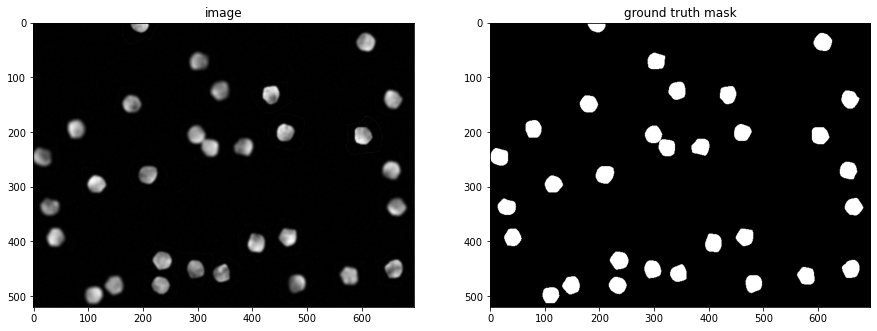

In [13]:
fig = plt.figure(figsize=(15,15))

fig.add_subplot(1,2,1)
plt.title('image')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,2,2)
plt.title('ground truth mask')
plt.imshow(mask, cmap='gray')

Here we can see a good example of an image and the ground truth mask. This is what we will be using to train our image segmentation model. The next step is to create a dataset and a dataloader.

In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    def __getitem__(self, i):
        # grab the image path from the current index
        imagePath = self.imagePaths[i]
        maskPath = self.maskPaths[i]

        image = tiff.imread(image_path + imagePath)
        mask = tiff.imread(mask_path + maskPath)
        
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return image, mask

In [15]:
train_batch_size = 32
test_batch_size = 32
img_size = 128

transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((img_size, img_size)),
                                 transforms.ToTensor()])

In [16]:
## TRAIN DATASET
train_dataset = SegmentationDataset(train_list, train_list, transforms)

train_loader = DataLoader(train_dataset, 
                          batch_size = train_batch_size, 
                          shuffle = True)

## TEST DATASET
test_dataset = SegmentationDataset(test_list, test_list, transforms)

test_loader = DataLoader(test_dataset, 
                         batch_size = test_batch_size, 
                         shuffle = True)

In [17]:
trainImg, trainLabels = next(iter(train_loader))
print('trainImg shape: ', trainImg.shape), print('trainLabels shape: ', trainLabels.shape)

print('----------------------------------------------------')

testImg, testLabels = next(iter(test_loader))
print('testImg shape: ', testImg.shape), print('testLabels shape: ', testLabels.shape)

trainImg shape:  torch.Size([32, 1, 128, 128])
trainLabels shape:  torch.Size([32, 1, 128, 128])
----------------------------------------------------
testImg shape:  torch.Size([32, 1, 128, 128])
testLabels shape:  torch.Size([32, 1, 128, 128])


(None, None)

In [18]:
def display_batch(image, label, batch_num):
    image = image[batch_num,:,:,:].numpy()[0,:,:]
    label = label[batch_num,:,:,:].numpy()[0,:,:]

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))
    
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(label, cmap='gray')
    
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

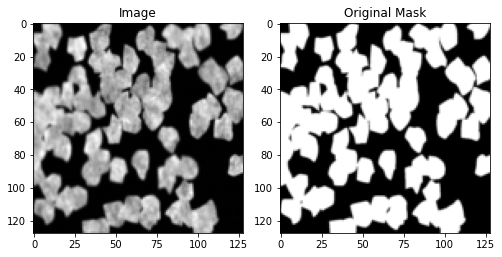

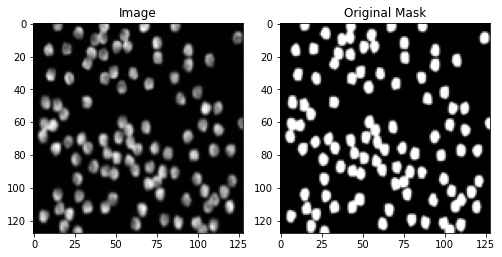

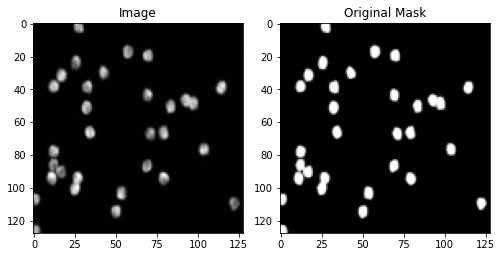

In [19]:
for i in range(3):
    display_batch(trainImg, trainLabels, i)

Now we have our dataloaded into train and test loaders, it is time to build our model.

**Define UNet model**

In [20]:
import torch.nn as nn

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [21]:
model = UNet(n_channels=1, n_classes=1)
model.to(device)

summary(model, (1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
       double_conv-7         [-1, 64, 128, 128]               0
            inconv-8         [-1, 64, 128, 128]               0
         MaxPool2d-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14          [-1, 128,

In [22]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, weight=1, smooth=0):
        inputs = inputs.flatten()
        targets = targets.flatten()
        
        bce = self.bce(inputs, targets)
        sigmoid = nn.Sigmoid()
        intersection = (sigmoid(inputs) * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (sigmoid(inputs).sum() + targets.sum() + smooth)

        dice_bce = weight * (bce + dice_loss)

        return dice_bce
    
def dice(pred, label):

    intersection = torch.sum(label * pred)
    union = torch.sum(label) + torch.sum(pred)
    dice = 2 * intersection / (union + 1e-7)

    return dice

In [23]:
criterion = BCEDiceLoss()
optimizer = Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [24]:
# number of epochs to train the model
tolerance = 2
min_delta = 0.05
n_epochs = 20

train_loss_list = []
valid_loss_list = []

train_dice_list = []
val_dice_list = []

lr_rate_list = []

time_list = []

valid_loss_min = np.Inf # keep track of minimum valid loss for saving best model

counter = 0

for epoch in range(1, n_epochs+1):
    
    start_time = time.time()

    # keep track of training and validation loss and dice
    train_loss = 0.0
    valid_loss = 0.0
    train_dice_score = 0.0
    val_dice_score = 0.0

    model.train()
    bar = tqdm(train_loader, postfix={"train_loss":0.0, "train_dice_score":0.0})
    for data, target in bar:
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss and dice
        train_loss += loss.item()*data.size(0)
        train_dice_cof = dice(output.cpu(), target.cpu()).item() ## train dice cof
        train_dice_score +=  train_dice_cof * data.size(0)
            
        bar.set_postfix(ordered_dict={"train_loss":loss.item(), "train_dice_score":train_dice_cof})

    model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(test_loader, postfix={"test_loss":0.0, "val_dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU
            data, target = data.cuda(), target.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update average validation loss and dice
            valid_loss += loss.item()*data.size(0)
            val_dice_cof = dice(output.cpu(), target.cpu()).item() # dice score per batch
            val_dice_score +=  val_dice_cof * data.size(0) # cumulative dice score, used to calculate average dice score for entire epoch
            
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "val_dice_score":val_dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    train_dice_score = train_dice_score/len(train_loader.dataset)
    val_dice_score = val_dice_score/len(test_loader.dataset)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    train_dice_list.append(train_dice_score)
    val_dice_list.append(val_dice_score)
    
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    end_time = time.time()
    
    time_list.append(end_time - start_time)
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f}  Training Dice Score: {:.6f}  Validation Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_dice_score, val_dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './models/UNET_depth_4.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)
    
    if epoch > 1:
        if abs(train_loss - valid_loss) > min_delta:
            counter += 1
        else:
            counter = 0
        
        if counter >= tolerance:
            print('early stopping at epoch: ', epoch)
            break

100%|████████████████████| 4/4 [00:03<00:00,  1.27it/s, valid_loss=0.736, val_dice_score=0.843]


Epoch: 1  Training Loss: 0.756048  Validation Loss: 0.685949  Training Dice Score: 0.780286  Validation Dice Score: 0.867835
Validation loss decreased (inf --> 0.685949).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.26it/s, valid_loss=0.715, val_dice_score=0.884]


Epoch: 2  Training Loss: 0.648297  Validation Loss: 0.658923  Training Dice Score: 0.910054  Validation Dice Score: 0.902034
Validation loss decreased (0.685949 --> 0.658923).  Saving model ...


100%|█████████████████████| 4/4 [00:03<00:00,  1.20it/s, valid_loss=0.607, val_dice_score=0.93]


Epoch: 3  Training Loss: 0.641618  Validation Loss: 0.650127  Training Dice Score: 0.920557  Validation Dice Score: 0.916676
Validation loss decreased (0.658923 --> 0.650127).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.26it/s, valid_loss=0.647, val_dice_score=0.925]


Epoch: 4  Training Loss: 0.638459  Validation Loss: 0.647845  Training Dice Score: 0.924306  Validation Dice Score: 0.921533
Validation loss decreased (0.650127 --> 0.647845).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.28it/s, valid_loss=0.639, val_dice_score=0.921]


Epoch: 5  Training Loss: 0.637435  Validation Loss: 0.650251  Training Dice Score: 0.925977  Validation Dice Score: 0.919870


100%|████████████████████| 4/4 [00:03<00:00,  1.28it/s, valid_loss=0.644, val_dice_score=0.926]


Epoch: 6  Training Loss: 0.636183  Validation Loss: 0.647580  Training Dice Score: 0.927198  Validation Dice Score: 0.922183
Validation loss decreased (0.647845 --> 0.647580).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.24it/s, valid_loss=0.659, val_dice_score=0.925]


Epoch: 7  Training Loss: 0.636158  Validation Loss: 0.648635  Training Dice Score: 0.927378  Validation Dice Score: 0.924690


100%|████████████████████| 4/4 [00:03<00:00,  1.26it/s, valid_loss=0.657, val_dice_score=0.921]


Epoch: 8  Training Loss: 0.635376  Validation Loss: 0.646578  Training Dice Score: 0.928113  Validation Dice Score: 0.923879
Validation loss decreased (0.647580 --> 0.646578).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.25it/s, valid_loss=0.611, val_dice_score=0.934]


Epoch: 9  Training Loss: 0.634929  Validation Loss: 0.646534  Training Dice Score: 0.928718  Validation Dice Score: 0.922539
Validation loss decreased (0.646578 --> 0.646534).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.26it/s, valid_loss=0.683, val_dice_score=0.915]


Epoch: 10  Training Loss: 0.634806  Validation Loss: 0.646349  Training Dice Score: 0.928892  Validation Dice Score: 0.924227
Validation loss decreased (0.646534 --> 0.646349).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.28it/s, valid_loss=0.681, val_dice_score=0.922]


Epoch: 11  Training Loss: 0.634491  Validation Loss: 0.645701  Training Dice Score: 0.929001  Validation Dice Score: 0.925486
Validation loss decreased (0.646349 --> 0.645701).  Saving model ...


100%|████████████████████| 4/4 [00:03<00:00,  1.29it/s, valid_loss=0.645, val_dice_score=0.926]


Epoch: 12  Training Loss: 0.633981  Validation Loss: 0.647108  Training Dice Score: 0.929509  Validation Dice Score: 0.924018


100%|████████████████████| 4/4 [00:03<00:00,  1.26it/s, valid_loss=0.698, val_dice_score=0.921]


Epoch: 13  Training Loss: 0.634281  Validation Loss: 0.647816  Training Dice Score: 0.929270  Validation Dice Score: 0.923691


100%|█████████████████████| 4/4 [00:03<00:00,  1.28it/s, valid_loss=0.68, val_dice_score=0.923]


Epoch: 14  Training Loss: 0.634376  Validation Loss: 0.646918  Training Dice Score: 0.929362  Validation Dice Score: 0.924577


100%|████████████████████| 4/4 [00:03<00:00,  1.30it/s, valid_loss=0.631, val_dice_score=0.927]


Epoch: 15  Training Loss: 0.634149  Validation Loss: 0.645883  Training Dice Score: 0.929580  Validation Dice Score: 0.924911


100%|████████████████████| 4/4 [00:03<00:00,  1.29it/s, valid_loss=0.724, val_dice_score=0.916]


Epoch: 16  Training Loss: 0.633374  Validation Loss: 0.649986  Training Dice Score: 0.929895  Validation Dice Score: 0.923045


100%|████████████████████| 4/4 [00:03<00:00,  1.28it/s, valid_loss=0.684, val_dice_score=0.921]


Epoch: 17  Training Loss: 0.634254  Validation Loss: 0.645430  Training Dice Score: 0.929646  Validation Dice Score: 0.924835
Validation loss decreased (0.645701 --> 0.645430).  Saving model ...


100%|████████████████████| 4/4 [00:02<00:00,  1.55it/s, valid_loss=0.595, val_dice_score=0.929]


Epoch: 18  Training Loss: 0.634270  Validation Loss: 0.646628  Training Dice Score: 0.929619  Validation Dice Score: 0.924953


100%|████████████████████| 4/4 [00:02<00:00,  1.41it/s, valid_loss=0.658, val_dice_score=0.916]


Epoch: 19  Training Loss: 0.634237  Validation Loss: 0.645851  Training Dice Score: 0.929733  Validation Dice Score: 0.925094


100%|████████████████████| 4/4 [00:02<00:00,  1.42it/s, valid_loss=0.703, val_dice_score=0.928]

Epoch: 20  Training Loss: 0.633783  Validation Loss: 0.649489  Training Dice Score: 0.929637  Validation Dice Score: 0.924804


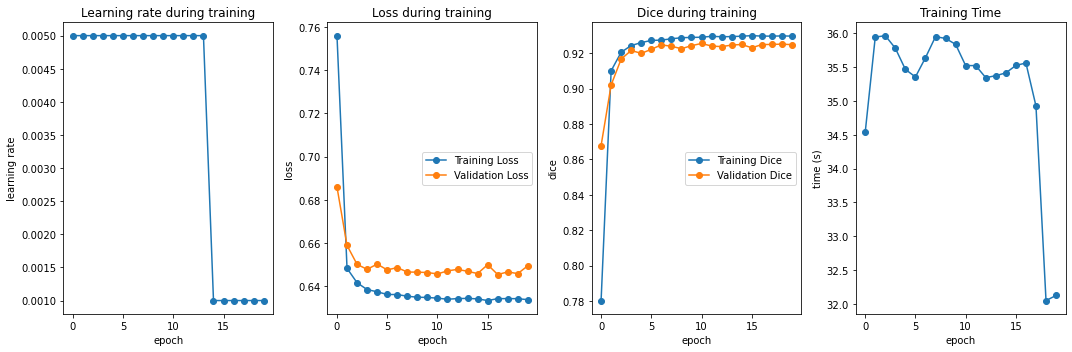

In [25]:
figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
        
# plot the original image, its mask, and the predicted mask
ax[0].plot(lr_rate_list, marker='o', label="learning rate")
ax[1].plot(train_loss_list,  marker='o', label="Training Loss")
ax[1].plot(valid_loss_list,  marker='o', label="Validation Loss")
ax[2].plot(train_dice_list, marker='o', label="Training Dice")
ax[2].plot(val_dice_list, marker='o', label="Validation Dice")
ax[3].plot(time_list, marker='o', label="Training Time")
    
# set the titles of the subplots
ax[0].set_title("Learning rate during training")
ax[1].set_title("Loss during training")
ax[2].set_title("Dice during training")
ax[3].set_title("Training Time")

# add legend for loss an dice
ax[1].legend(loc='right')
ax[2].legend(loc='right')

# set the axis labels of the subplots
for i in range(4):
    ax[i].set_xlabel('epoch')
ax[0].set_ylabel('learning rate')
ax[1].set_ylabel('loss')
ax[2].set_ylabel('dice')
ax[3].set_ylabel('time (s)')
    
# set the layout of the figure and display it
figure.tight_layout()
figure.show()    

In [26]:
# load best model
model.load_state_dict(torch.load('./models/UNET_depth_4.pt'))
model.eval();

In [27]:
outputs = model(testImg.to(device)).cpu().detach()
outputs.shape

torch.Size([32, 1, 128, 128])

In [28]:
def display_pred(image, label, pred, batch_num):
    dice_score = dice(pred[batch_num,:,:], label[batch_num,:,:]).item()
    image = image[batch_num,:,:,:].numpy()[0,:,:]
    label = label[batch_num,:,:,:].numpy()[0,:,:]
    pred = pred[batch_num,:,:,:].cpu().detach().numpy()[0,:,:]
    
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
        
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(label, cmap='gray')
    ax[2].imshow(pred, cmap='gray')
    
    # set the titles of the subplots
    ax[0].set_title("Original Image")
    ax[1].set_title("Ground Truth Mask")
    ax[2].set_title("Predicted Mask (dice score: {:.4f})".format(dice_score))
    
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()    

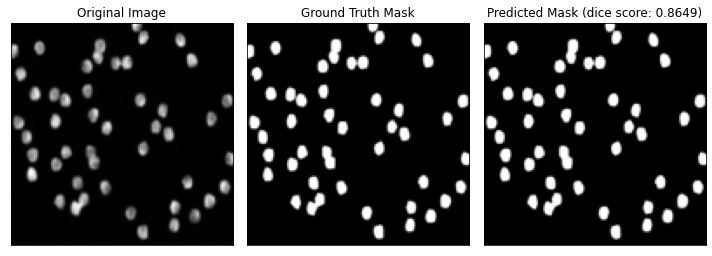

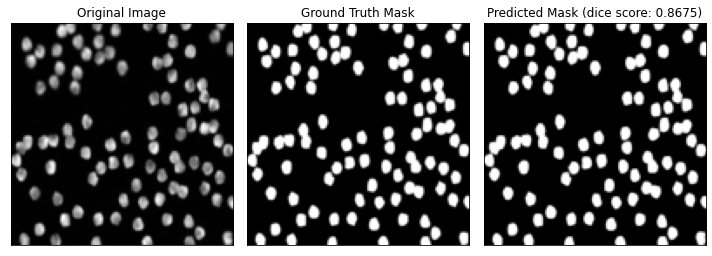

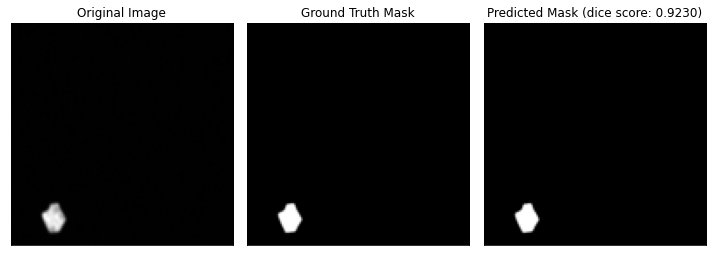

In [31]:
for i in random.sample(range(1, testImg.shape[0]), 3):
    display_pred(testImg, testLabels, outputs, i)